## Drug Discover Pipeline of CAMK2A

In [1]:
import logging

from collections import Counter
from operator import itemgetter
from lxml import etree

# from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools, Lipinski
from rdkit.Chem import Draw 
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.SaltRemover import SaltRemover
from IPython.display import Image, display
import pandas as pd
import json
import sys
from log_progress import *
from chembl_webresource_client.settings import Settings
from chembl_webresource_client.new_client import new_client
import matplotlib
import numpy as np
import matplotlib.pyplot as plt 
import pubchempy as pcp
from IPython.display import HTML
import seaborn as sns
import sweetviz as sv
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from scipy.stats import mannwhitneyu 
from sklearn.model_selection import train_test_split
%matplotlib inline

## Target Identifcation done in CHEMBL and get know compounds of intrest

In [2]:
chembl_id = "CHEMBL4147"

In [3]:
records = new_client.activity.filter(target_chembl_id=chembl_id)

len(records)

1839

In [4]:
# Target Search
target = new_client.target
target_query = target.search('CHEMBL4147')
targets = pd.DataFrame.from_dict(target_query)
targets[:10]
# Assigning the selected target as entry 1
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL4147'

# Only Instrested in compounds with bioactivity value IC50 to distingusigh compounds between active and inactive compounds for generating a prediction algorithm to test other data for SAR relationship

In [5]:
activity = new_client.activity
result = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [6]:
# Converting dictionary to dataframe
df = pd.DataFrame.from_dict(result)
df.head(3)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1755312,[],CHEMBL868614,Inhibition of CamK2alpha,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,nM,UO_0000065,None,1.0
1,None,1755332,[],CHEMBL868614,Inhibition of CamK2alpha,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,nM,UO_0000065,None,8000.0
2,None,3447804,[],CHEMBL1250110,Inhibition of CAMK2 F89G mutant,B,Q9UQM7,F89G,BAO_0000190,BAO_0000019,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,uM,UO_0000065,None,0.097


In [7]:
# Getting the shape of the dataframe created
df.shape
# Saving the dataframe to a csv file
df.to_csv('Target_data_raw.csv',index=False)

In [8]:
df1 = df[df.value.notna()] #cleaning the data
df2 = df1[df1.canonical_smiles.notna()] #removing the data without smiles.
df2.head(3)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1755312,[],CHEMBL868614,Inhibition of CamK2alpha,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,nM,UO_0000065,None,1.0
1,None,1755332,[],CHEMBL868614,Inhibition of CamK2alpha,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,nM,UO_0000065,None,8000.0
2,None,3447804,[],CHEMBL1250110,Inhibition of CAMK2 F89G mutant,B,Q9UQM7,F89G,BAO_0000190,BAO_0000019,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,uM,UO_0000065,None,0.097
3,None,3447814,[],CHEMBL1250110,Inhibition of CAMK2 F89G mutant,B,Q9UQM7,F89G,BAO_0000190,BAO_0000019,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,uM,UO_0000065,None,0.008
4,None,10849705,[],CHEMBL2019664,Inhibition of CAMK2A,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,uM,UO_0000065,None,40.0
5,None,12039213,[],CHEMBL2148933,Inhibition of alphaCaMK2 using GST-NR2A as sub...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,uM,UO_0000065,None,13.0
6,None,12039214,[],CHEMBL2148933,Inhibition of alphaCaMK2 using GST-NR2A as sub...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,uM,UO_0000065,None,21.0
7,None,12039216,[],CHEMBL2148931,Inhibition of autophosphorylated alphaCaMK2 us...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,uM,UO_0000065,None,45.0
8,None,12039217,[],CHEMBL2148930,Inhibition of autophosphorylated alphaCaMK2 us...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,uM,UO_0000065,None,34.0
9,None,12039218,[],CHEMBL2148929,Inhibition of alphaCaMK2 autophosphorylation a...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,uM,UO_0000065,None,33.0


In [9]:
# Dropping the duplicates
df3 = df2.drop_duplicates(['canonical_smiles'])
df3.head(3)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1755312,[],CHEMBL868614,Inhibition of CamK2alpha,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,nM,UO_0000065,None,1.0
1,None,1755332,[],CHEMBL868614,Inhibition of CamK2alpha,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,nM,UO_0000065,None,8000.0
2,None,3447804,[],CHEMBL1250110,Inhibition of CAMK2 F89G mutant,B,Q9UQM7,F89G,BAO_0000190,BAO_0000019,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,uM,UO_0000065,None,0.097
3,None,3447814,[],CHEMBL1250110,Inhibition of CAMK2 F89G mutant,B,Q9UQM7,F89G,BAO_0000190,BAO_0000019,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,uM,UO_0000065,None,0.008
4,None,10849705,[],CHEMBL2019664,Inhibition of CAMK2A,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,uM,UO_0000065,None,40.0
5,None,12039213,[],CHEMBL2148933,Inhibition of alphaCaMK2 using GST-NR2A as sub...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,uM,UO_0000065,None,13.0
11,None,12039227,[],CHEMBL2148933,Inhibition of alphaCaMK2 using GST-NR2A as sub...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,uM,UO_0000065,None,24.0
12,None,12039228,[],CHEMBL2148933,Inhibition of alphaCaMK2 using GST-NR2A as sub...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,uM,UO_0000065,None,37.0
13,None,12039229,[],CHEMBL2148933,Inhibition of alphaCaMK2 using GST-NR2A as sub...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,uM,UO_0000065,None,37.0
17,None,12039239,[],CHEMBL2148933,Inhibition of alphaCaMK2 using GST-NR2A as sub...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,CaM kinase II alpha,9606,None,None,IC50,uM,UO_0000065,None,1.49


In [10]:
# Classifying compounds by labeling into active, intermediate and inactive
bioactivity_class = []
for i in df3.standard_value:
  if float(i) >= 10000.0:
    bioactivity_class.append('inactive')
  elif float(i) <= 1000.0:
    bioactivity_class.append('active')
  else:
    bioactivity_class.append('intermediate')

In [11]:
# Combining the columns molecule_chembl_id,canonical_smiles,standard_value
columns = ['molecule_chembl_id','canonical_smiles','standard_value']
df4 = df3[columns]
df4[10:50]

,molecule_chembl_id,canonical_smiles,standard_value
21,CHEMBL181529,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)on2)ccc1O,11370.0
25,CHEMBL2324596,Cc1cccc(Cc2n[nH]c3ncncc23)c1,10000.0
26,CHEMBL2335479,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(N)=O)NC(=O)CNC...,50.0
27,CHEMBL2335442,CC[C@H](C)[C@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=...,40.0
28,CHEMBL2335444,CC[C@H](C)[C@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=...,30.0
29,CHEMBL3593777,N#Cc1ccc(N2CC[C@@H](Nc3c(C(N)=O)cnc4[nH]ccc34)...,1000.0
30,CHEMBL3745885,Cn1c(=O)c(S(=O)(=O)c2ccc(F)cc2F)cc2cnc(Nc3ccc4...,10000.0
31,CHEMBL3903725,Nc1ccc(-c2ccc3ncc4c(=O)[nH]c(=O)n(-c5cccc(C(F)...,10000.0
32,CHEMBL2006765,CCCNC(=O)c1ccc(Nc2nc(NCC(F)(F)F)c3cc[nH]c3n2)cc1,10000.0
33,CHEMBL4078893,FC(F)(F)CNc1nc(Nc2ccc(N3CCOCC3)c(Cl)c2)nc2ccoc12,10000.0


In [12]:
# Concatenating the bioactivity_class column
df4['class'] = bioactivity_class
df4

/tmp/ipykernel_61662/3172209521.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['class'] = bioactivity_class


,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,1.0,active
1,CHEMBL213618,CNc1nccc(-c2ccc(C(=O)N[C@H](CN)Cc3ccc(Cl)cc3Cl...,8000.0,intermediate
2,CHEMBL264406,CC(C)(C)n1nc(-c2cccc3ccccc23)c2c(N)ncnc21,97.0,active
3,CHEMBL573578,CC(C)(C)n1nc(Cc2cccc3ccccc23)c2c(N)ncnc21,8.0,active
4,CHEMBL2017214,CSc1ccccc1Nc1nc(N2CCNCC2)nc2c(NCC3CC3)ncnc12,40000.0,inactive
5,CHEMBL116438,COc1cc(/C=C/C(=O)/C=C(O)/C=C/c2ccc(O)c(OC)c2)c...,13000.0,inactive
11,CHEMBL179512,COc1cc(/C=C/C(O)=C/C(=O)/C=C/c2ccc(O)cc2)ccc1O,24000.0,inactive
12,CHEMBL105350,O=C(/C=C/c1ccc(O)cc1)CC(=O)/C=C/c1ccc(O)cc1,37000.0,inactive
13,CHEMBL258741,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)n(-c3ccc...,37000.0,inactive
17,CHEMBL180239,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)[nH]n2)c...,1490.0,intermediate


In [13]:
# Saving the dataframe to csv
df4.to_csv('Target_data_preprocessed.csv',index=False)

In [14]:
# Reading the csv file into DataFrame
df = pd.read_csv('Target_data_preprocessed.csv')
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,1.0,active
1,CHEMBL213618,CNc1nccc(-c2ccc(C(=O)N[C@H](CN)Cc3ccc(Cl)cc3Cl...,8000.0,intermediate
2,CHEMBL264406,CC(C)(C)n1nc(-c2cccc3ccccc23)c2c(N)ncnc21,97.0,active
3,CHEMBL573578,CC(C)(C)n1nc(Cc2cccc3ccccc23)c2c(N)ncnc21,8.0,active
4,CHEMBL2017214,CSc1ccccc1Nc1nc(N2CCNCC2)nc2c(NCC3CC3)ncnc12,40000.0,inactive
5,CHEMBL116438,COc1cc(/C=C/C(=O)/C=C(O)/C=C/c2ccc(O)c(OC)c2)c...,13000.0,inactive
6,CHEMBL179512,COc1cc(/C=C/C(O)=C/C(=O)/C=C/c2ccc(O)cc2)ccc1O,24000.0,inactive
7,CHEMBL105350,O=C(/C=C/c1ccc(O)cc1)CC(=O)/C=C/c1ccc(O)cc1,37000.0,inactive
8,CHEMBL258741,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)n(-c3ccc...,37000.0,inactive
9,CHEMBL180239,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)[nH]n2)c...,1490.0,intermediate


In [15]:
# Importing the necessary libraries
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [16]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [17]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [18]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL388978,1.0,active,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...
1,CHEMBL213618,8000.0,intermediate,CNc1nccc(-c2ccc(C(=O)N[C@H](CN)Cc3ccc(Cl)cc3Cl...
2,CHEMBL264406,97.0,active,CC(C)(C)n1nc(-c2cccc3ccccc23)c2c(N)ncnc21
3,CHEMBL573578,8.0,active,CC(C)(C)n1nc(Cc2cccc3ccccc23)c2c(N)ncnc21
4,CHEMBL2017214,40000.0,inactive,CSc1ccccc1Nc1nc(N2CCNCC2)nc2c(NCC3CC3)ncnc12
5,CHEMBL116438,13000.0,inactive,COc1cc(/C=C/C(=O)/C=C(O)/C=C/c2ccc(O)c(OC)c2)c...
6,CHEMBL179512,24000.0,inactive,COc1cc(/C=C/C(O)=C/C(=O)/C=C/c2ccc(O)cc2)ccc1O
7,CHEMBL105350,37000.0,inactive,O=C(/C=C/c1ccc(O)cc1)CC(=O)/C=C/c1ccc(O)cc1
8,CHEMBL258741,37000.0,inactive,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)n(-c3ccc...
9,CHEMBL180239,1490.0,intermediate,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)[nH]n2)c...


In [19]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [20]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,466.541,4.35400,2.0,6.0
1,436.368,3.85340,3.0,6.0
2,317.396,3.98370,1.0,5.0
3,331.423,3.90750,1.0,5.0
4,422.562,3.11680,3.0,9.0
5,368.385,3.85260,3.0,6.0
6,338.359,3.84400,3.0,5.0
7,308.333,3.35270,2.0,4.0
8,440.499,5.64150,2.0,6.0
9,364.401,4.17890,3.0,5.0


In [21]:
# Dataframe 1
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,466.541,4.35400,2.0,6.0
1,436.368,3.85340,3.0,6.0
2,317.396,3.98370,1.0,5.0
3,331.423,3.90750,1.0,5.0
4,422.562,3.11680,3.0,9.0
5,368.385,3.85260,3.0,6.0
6,338.359,3.84400,3.0,5.0
7,308.333,3.35270,2.0,4.0
8,440.499,5.64150,2.0,6.0
9,364.401,4.17890,3.0,5.0


In [22]:
# Dataframe 2
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,1.0,active
1,CHEMBL213618,CNc1nccc(-c2ccc(C(=O)N[C@H](CN)Cc3ccc(Cl)cc3Cl...,8000.0,intermediate
2,CHEMBL264406,CC(C)(C)n1nc(-c2cccc3ccccc23)c2c(N)ncnc21,97.0,active
3,CHEMBL573578,CC(C)(C)n1nc(Cc2cccc3ccccc23)c2c(N)ncnc21,8.0,active
4,CHEMBL2017214,CSc1ccccc1Nc1nc(N2CCNCC2)nc2c(NCC3CC3)ncnc12,40000.0,inactive
5,CHEMBL116438,COc1cc(/C=C/C(=O)/C=C(O)/C=C/c2ccc(O)c(OC)c2)c...,13000.0,inactive
6,CHEMBL179512,COc1cc(/C=C/C(O)=C/C(=O)/C=C/c2ccc(O)cc2)ccc1O,24000.0,inactive
7,CHEMBL105350,O=C(/C=C/c1ccc(O)cc1)CC(=O)/C=C/c1ccc(O)cc1,37000.0,inactive
8,CHEMBL258741,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)n(-c3ccc...,37000.0,inactive
9,CHEMBL180239,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)[nH]n2)c...,1490.0,intermediate


In [23]:
# Combining the two columns
df_combined = pd.concat([df,df_lipinski],axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,1.0,active,466.541,4.35400,2.0,6.0
1,CHEMBL213618,CNc1nccc(-c2ccc(C(=O)N[C@H](CN)Cc3ccc(Cl)cc3Cl...,8000.0,intermediate,436.368,3.85340,3.0,6.0
2,CHEMBL264406,CC(C)(C)n1nc(-c2cccc3ccccc23)c2c(N)ncnc21,97.0,active,317.396,3.98370,1.0,5.0
3,CHEMBL573578,CC(C)(C)n1nc(Cc2cccc3ccccc23)c2c(N)ncnc21,8.0,active,331.423,3.90750,1.0,5.0
4,CHEMBL2017214,CSc1ccccc1Nc1nc(N2CCNCC2)nc2c(NCC3CC3)ncnc12,40000.0,inactive,422.562,3.11680,3.0,9.0
5,CHEMBL116438,COc1cc(/C=C/C(=O)/C=C(O)/C=C/c2ccc(O)c(OC)c2)c...,13000.0,inactive,368.385,3.85260,3.0,6.0
6,CHEMBL179512,COc1cc(/C=C/C(O)=C/C(=O)/C=C/c2ccc(O)cc2)ccc1O,24000.0,inactive,338.359,3.84400,3.0,5.0
7,CHEMBL105350,O=C(/C=C/c1ccc(O)cc1)CC(=O)/C=C/c1ccc(O)cc1,37000.0,inactive,308.333,3.35270,2.0,4.0
8,CHEMBL258741,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)n(-c3ccc...,37000.0,inactive,440.499,5.64150,2.0,6.0
9,CHEMBL180239,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)[nH]n2)c...,1490.0,intermediate,364.401,4.17890,3.0,5.0


In [24]:
# Saving this to csv file
df_combined.to_csv('Target_combined_dataframe.csv',index=False)

,molecule_chembl_id,ROMol,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL388978,,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,1.0,active,466.541,4.35400,2.0,6.0
1,CHEMBL213618,,CNc1nccc(-c2ccc(C(=O)N[C@H](CN)Cc3ccc(Cl)cc3Cl...,8000.0,intermediate,436.368,3.85340,3.0,6.0
2,CHEMBL264406,,CC(C)(C)n1nc(-c2cccc3ccccc23)c2c(N)ncnc21,97.0,active,317.396,3.98370,1.0,5.0
3,CHEMBL573578,,CC(C)(C)n1nc(Cc2cccc3ccccc23)c2c(N)ncnc21,8.0,active,331.423,3.90750,1.0,5.0
4,CHEMBL2017214,,CSc1ccccc1Nc1nc(N2CCNCC2)nc2c(NCC3CC3)ncnc12,40000.0,inactive,422.562,3.11680,3.0,9.0
5,CHEMBL116438,,COc1cc(/C=C/C(=O)/C=C(O)/C=C/c2ccc(O)c(OC)c2)c...,13000.0,inactive,368.385,3.85260,3.0,6.0
6,CHEMBL179512,,COc1cc(/C=C/C(O)=C/C(=O)/C=C/c2ccc(O)cc2)ccc1O,24000.0,inactive,338.359,3.84400,3.0,5.0
7,CHEMBL105350,,O=C(/C=C/c1ccc(O)cc1)CC(=O)/C=C/c1ccc(O)cc1,37000.0,inactive,308.333,3.35270,2.0,4.0
8,CHEMBL258741,,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)n(-c3ccc...,37000.0,inactive,440.499,5.64150,2.0,6.0
9,CHEMBL180239,,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)[nH]n2)c...,1490.0,intermediate,364.401,4.17890,3.0,5.0

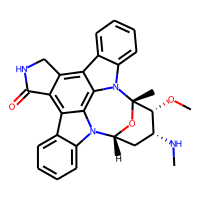
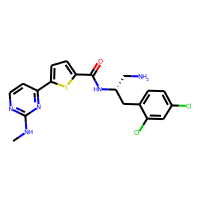
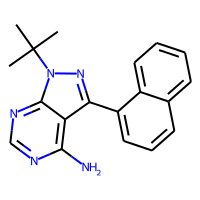
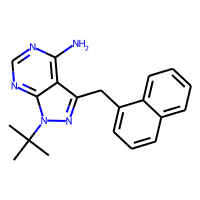
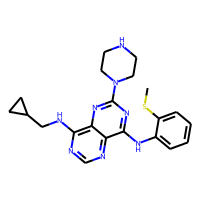
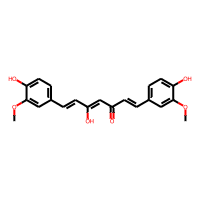
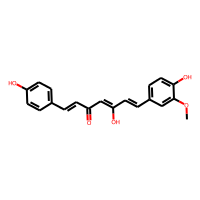
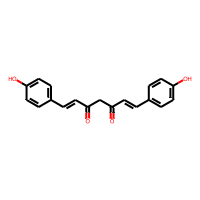
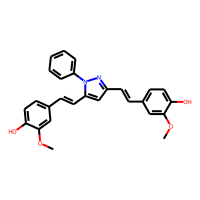
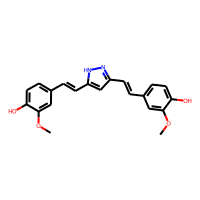
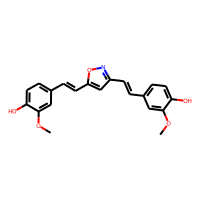
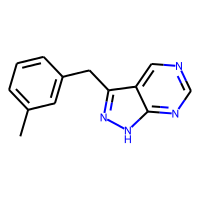
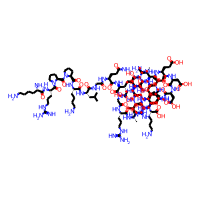
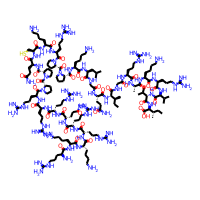
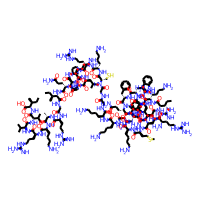
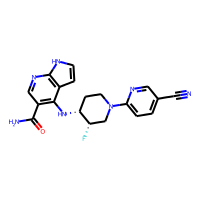
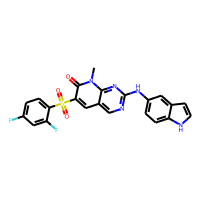
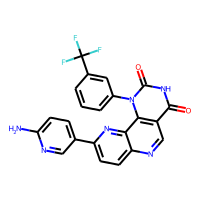
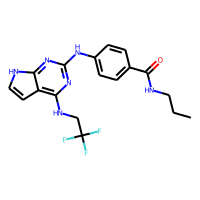
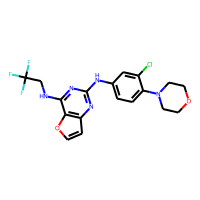
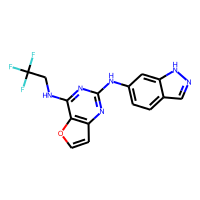
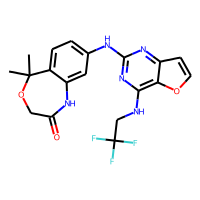
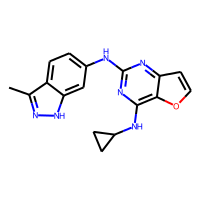
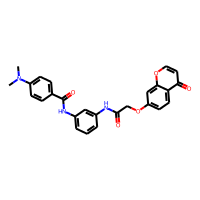
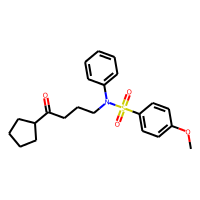
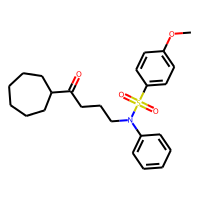
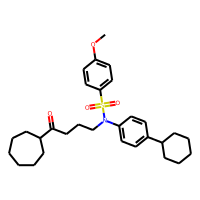
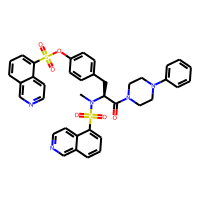
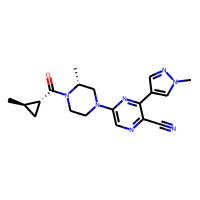
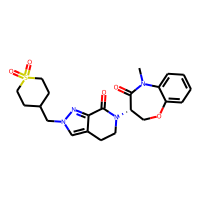

In [25]:
PandasTools.AddMoleculeColumnToFrame(df_combined, smilesCol = 'canonical_smiles',includeFingerprints=True)
df_combined[['molecule_chembl_id','ROMol','canonical_smiles','standard_value', 'class', 'MW','LogP','NumHDonors','NumHAcceptors']]

In [26]:
# Creating custom pIC50()

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:

        # Converts nM to M
        molar = i*(10**-9) 
        
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [27]:
# Noting the min and max values of log
max = -np.log10( (10**-9)* 100000000 )
min = -np.log10( (10**-9)* 10000000000 )
max,min

(1.0, -1.0)

In [28]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

/tmp/ipykernel_61662/3416609517.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x = input.drop('standard_value', 1)


,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,ROMol,standard_value_norm
0,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,active,466.541,4.35400,2.0,6.0,,1.0
1,CHEMBL213618,CNc1nccc(-c2ccc(C(=O)N[C@H](CN)Cc3ccc(Cl)cc3Cl...,intermediate,436.368,3.85340,3.0,6.0,,8000.0
2,CHEMBL264406,CC(C)(C)n1nc(-c2cccc3ccccc23)c2c(N)ncnc21,active,317.396,3.98370,1.0,5.0,,97.0
3,CHEMBL573578,CC(C)(C)n1nc(Cc2cccc3ccccc23)c2c(N)ncnc21,active,331.423,3.90750,1.0,5.0,,8.0
4,CHEMBL2017214,CSc1ccccc1Nc1nc(N2CCNCC2)nc2c(NCC3CC3)ncnc12,inactive,422.562,3.11680,3.0,9.0,,40000.0
5,CHEMBL116438,COc1cc(/C=C/C(=O)/C=C(O)/C=C/c2ccc(O)c(OC)c2)c...,inactive,368.385,3.85260,3.0,6.0,,13000.0
6,CHEMBL179512,COc1cc(/C=C/C(O)=C/C(=O)/C=C/c2ccc(O)cc2)ccc1O,inactive,338.359,3.84400,3.0,5.0,,24000.0
7,CHEMBL105350,O=C(/C=C/c1ccc(O)cc1)CC(=O)/C=C/c1ccc(O)cc1,inactive,308.333,3.35270,2.0,4.0,,37000.0
8,CHEMBL258741,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)n(-c3ccc...,inactive,440.499,5.64150,2.0,6.0,,37000.0
9,CHEMBL180239,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)[nH]n2)c...,intermediate,364.401,4.17890,3.0,5.0,,1490.0

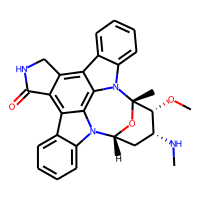
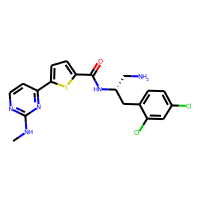
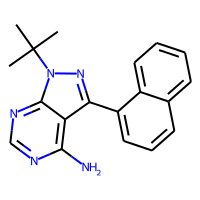
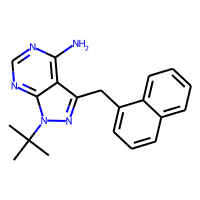
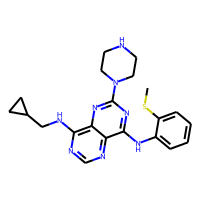
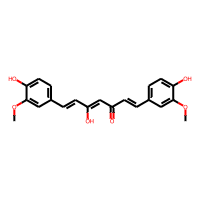
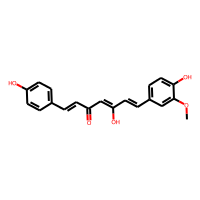
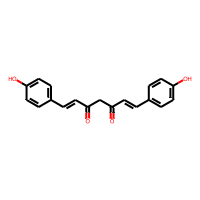
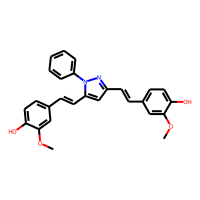
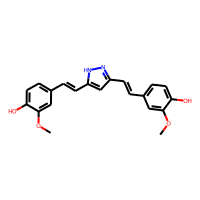
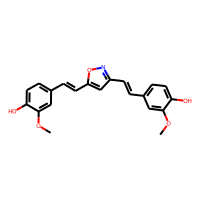
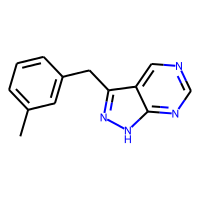
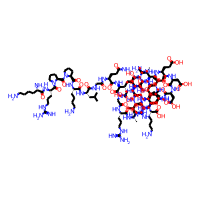
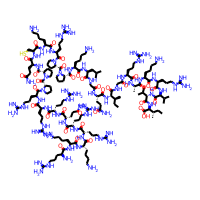
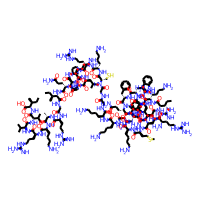
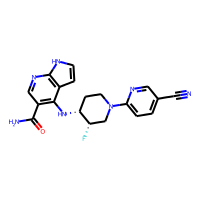
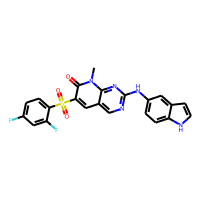
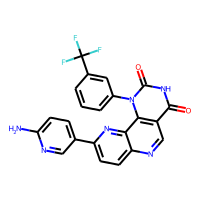
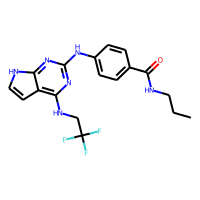
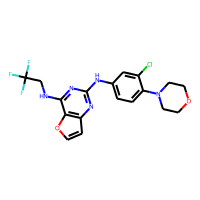
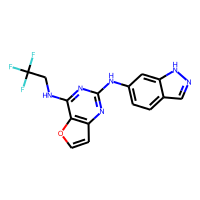
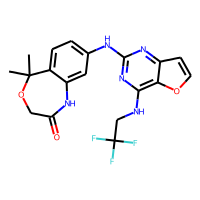
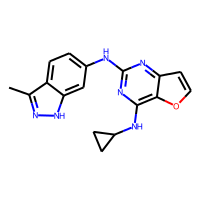
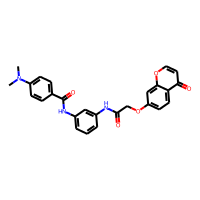
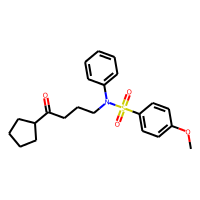
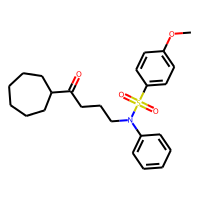
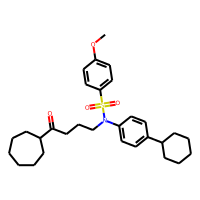
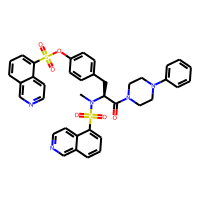
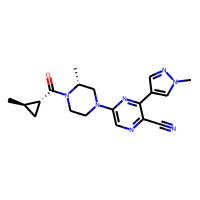
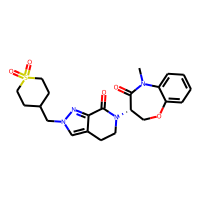

In [29]:
# Calling the function to cap values to 10000000000
df_norm = norm_value(df_combined)
df_norm

/tmp/ipykernel_61662/1829614713.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x = input.drop('standard_value_norm', 1)


,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,ROMol,pIC50
0,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,active,466.541,4.35400,2.0,6.0,,9.000000
1,CHEMBL213618,CNc1nccc(-c2ccc(C(=O)N[C@H](CN)Cc3ccc(Cl)cc3Cl...,intermediate,436.368,3.85340,3.0,6.0,,5.096910
2,CHEMBL264406,CC(C)(C)n1nc(-c2cccc3ccccc23)c2c(N)ncnc21,active,317.396,3.98370,1.0,5.0,,7.013228
3,CHEMBL573578,CC(C)(C)n1nc(Cc2cccc3ccccc23)c2c(N)ncnc21,active,331.423,3.90750,1.0,5.0,,8.096910
4,CHEMBL2017214,CSc1ccccc1Nc1nc(N2CCNCC2)nc2c(NCC3CC3)ncnc12,inactive,422.562,3.11680,3.0,9.0,,4.397940
5,CHEMBL116438,COc1cc(/C=C/C(=O)/C=C(O)/C=C/c2ccc(O)c(OC)c2)c...,inactive,368.385,3.85260,3.0,6.0,,4.886057
6,CHEMBL179512,COc1cc(/C=C/C(O)=C/C(=O)/C=C/c2ccc(O)cc2)ccc1O,inactive,338.359,3.84400,3.0,5.0,,4.619789
7,CHEMBL105350,O=C(/C=C/c1ccc(O)cc1)CC(=O)/C=C/c1ccc(O)cc1,inactive,308.333,3.35270,2.0,4.0,,4.431798
8,CHEMBL258741,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)n(-c3ccc...,inactive,440.499,5.64150,2.0,6.0,,4.431798
9,CHEMBL180239,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)[nH]n2)c...,intermediate,364.401,4.17890,3.0,5.0,,5.826814

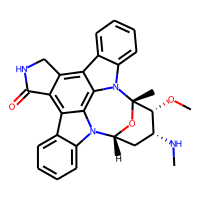
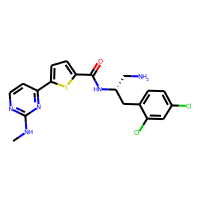
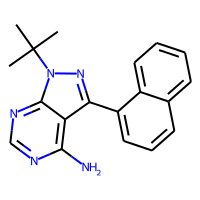
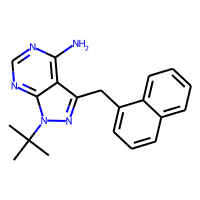
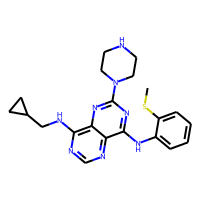
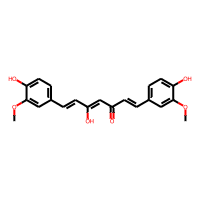
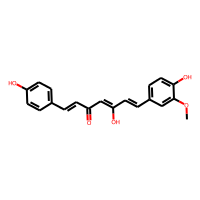
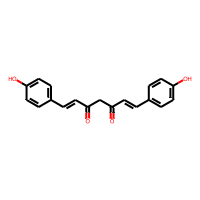
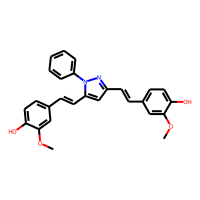
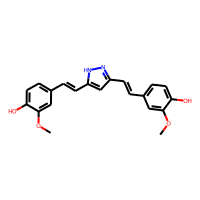
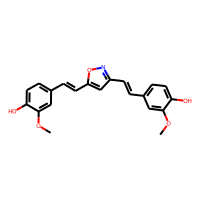
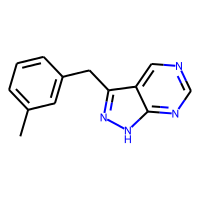
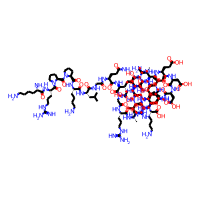
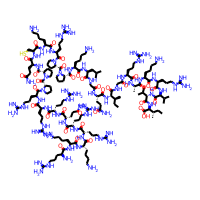
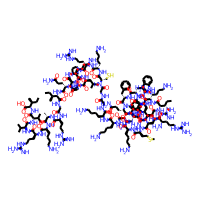
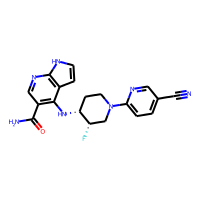
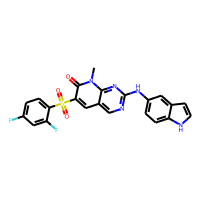
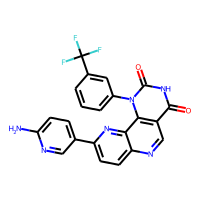
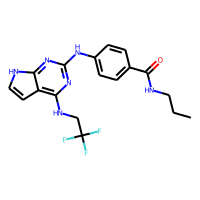
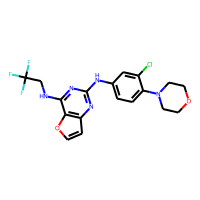
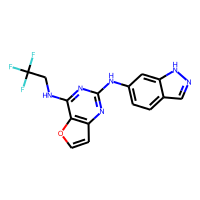
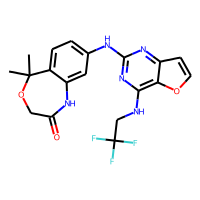
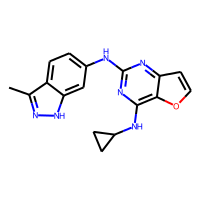
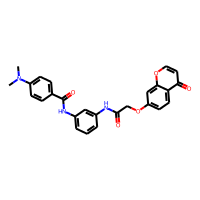
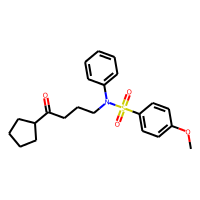
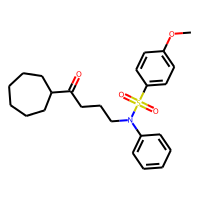
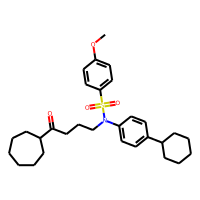
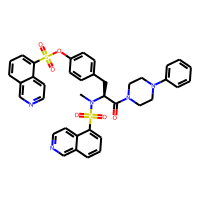
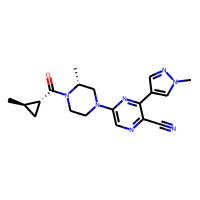
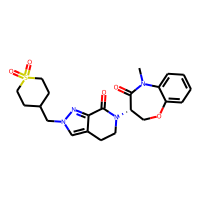

In [30]:
# Converting pIC50 from df
df_final = pIC50(df_norm)
df_final

In [31]:
# Saving to csv file
df_final.to_csv('bioactivity_class_pic50.csv',index=False)



,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,ROMol,pIC50
0,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,active,466.541,4.35400,2.0,6.0,,9.000000
1,CHEMBL213618,CNc1nccc(-c2ccc(C(=O)N[C@H](CN)Cc3ccc(Cl)cc3Cl...,intermediate,436.368,3.85340,3.0,6.0,,5.096910
2,CHEMBL264406,CC(C)(C)n1nc(-c2cccc3ccccc23)c2c(N)ncnc21,active,317.396,3.98370,1.0,5.0,,7.013228
3,CHEMBL573578,CC(C)(C)n1nc(Cc2cccc3ccccc23)c2c(N)ncnc21,active,331.423,3.90750,1.0,5.0,,8.096910
4,CHEMBL2017214,CSc1ccccc1Nc1nc(N2CCNCC2)nc2c(NCC3CC3)ncnc12,inactive,422.562,3.11680,3.0,9.0,,4.397940
5,CHEMBL116438,COc1cc(/C=C/C(=O)/C=C(O)/C=C/c2ccc(O)c(OC)c2)c...,inactive,368.385,3.85260,3.0,6.0,,4.886057
6,CHEMBL179512,COc1cc(/C=C/C(O)=C/C(=O)/C=C/c2ccc(O)cc2)ccc1O,inactive,338.359,3.84400,3.0,5.0,,4.619789
7,CHEMBL105350,O=C(/C=C/c1ccc(O)cc1)CC(=O)/C=C/c1ccc(O)cc1,inactive,308.333,3.35270,2.0,4.0,,4.431798
8,CHEMBL258741,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)n(-c3ccc...,inactive,440.499,5.64150,2.0,6.0,,4.431798
9,CHEMBL180239,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)[nH]n2)c...,intermediate,364.401,4.17890,3.0,5.0,,5.826814

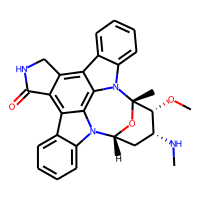
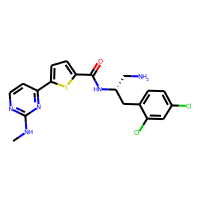
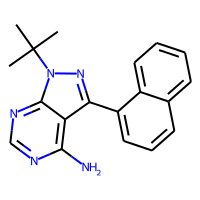
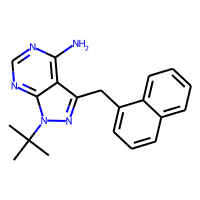
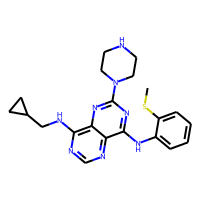
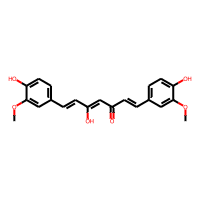
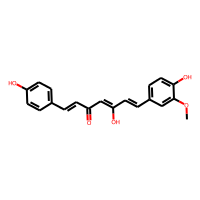
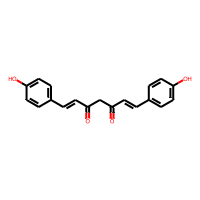
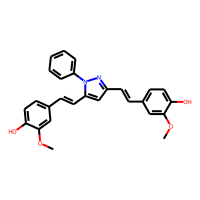
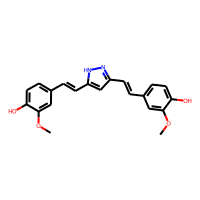
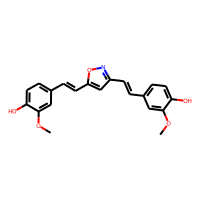
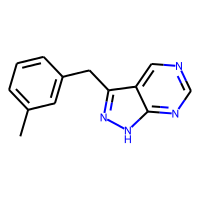
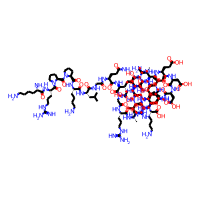
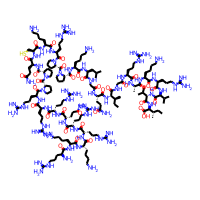
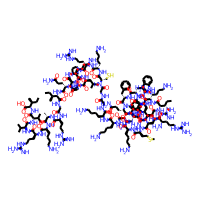
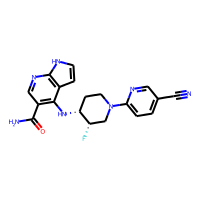
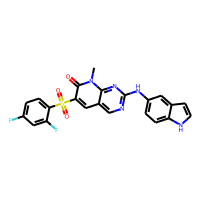
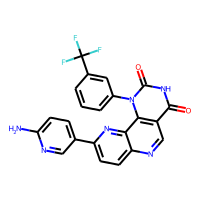
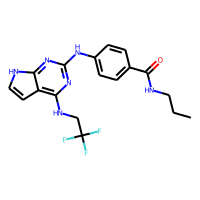
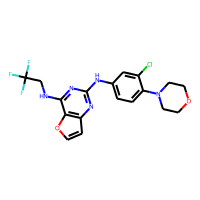
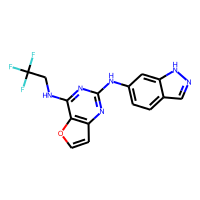
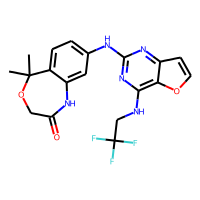
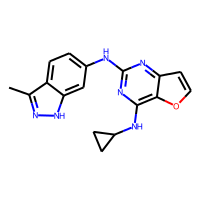
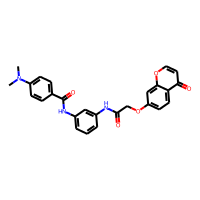
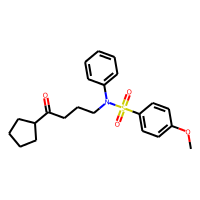
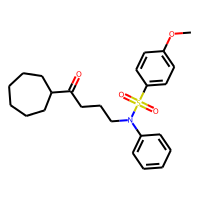
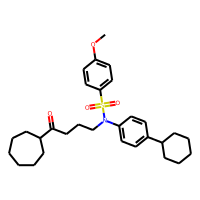
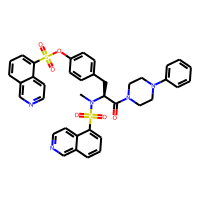
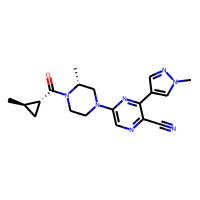
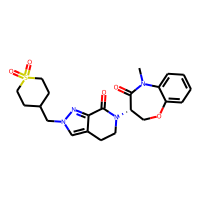

In [32]:
df_final

In [33]:
df = df_final[df_final['class'] != 'intermediate']

In [34]:
df['class'].value_counts()

inactive    16
active      11
Name: class, dtype: int64

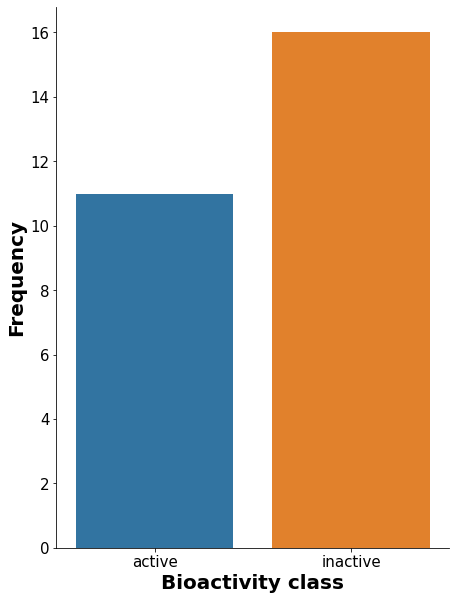

In [35]:
plt.figure(figsize=(6.5, 8.5))

sns.countplot(x='class', data=df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('Frequency', fontsize=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)
sns.set(style='ticks')
sns.despine(top=True)
plt.tight_layout()
plt.savefig('plot_bioactivity_class.png')

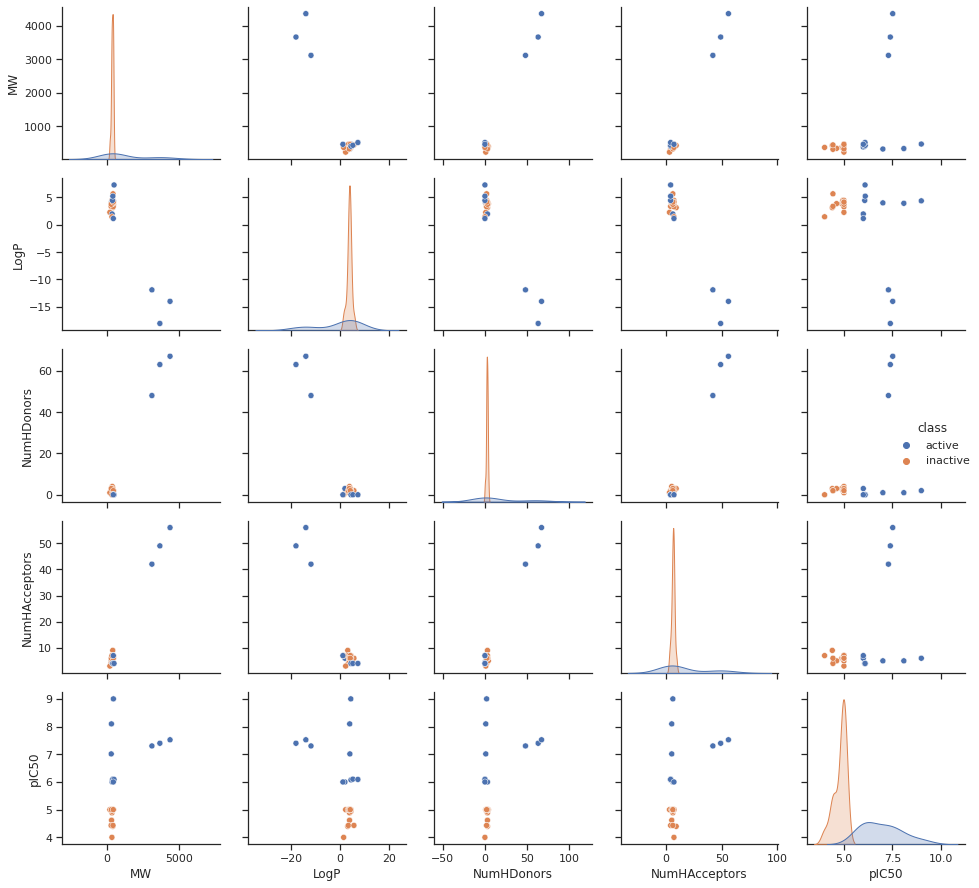

In [36]:
selection = ['class','MW','LogP','NumHDonors','NumHAcceptors','pIC50']
sns.pairplot(df[selection], hue='class')
plt.tight_layout()
plt.savefig('Pairplot.png',dpi=300)

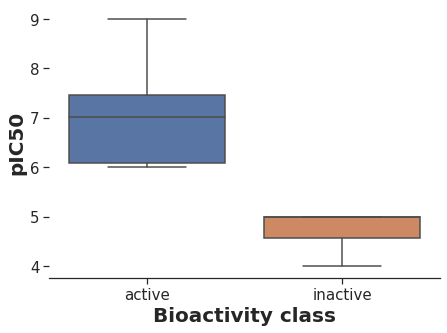

In [37]:
fig = plt.figure(figsize=(7,5))
sns.boxplot(x='class', y='pIC50', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('pIC50', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)
sns.despine(top=True, left=True)
plt.savefig('boxplot_pIC50.png',dpi=300);

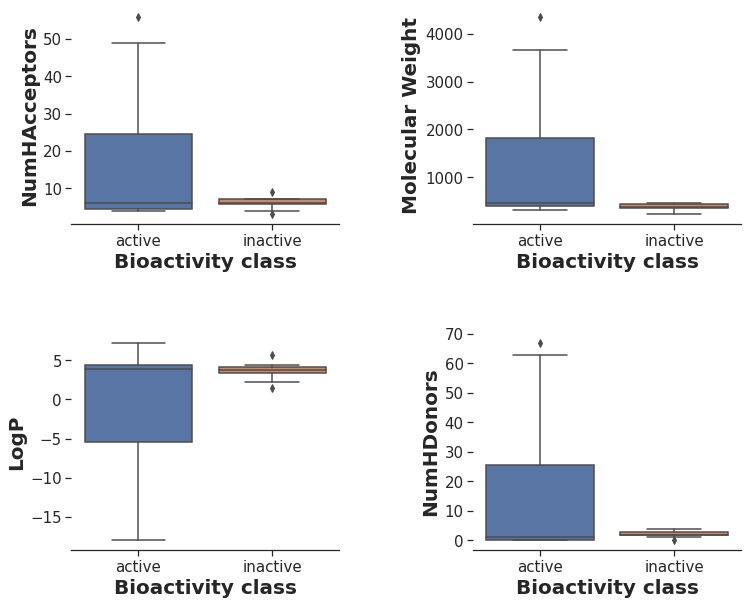

In [38]:
fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(hspace=0.5,wspace=0.5)
fig.add_subplot(2,2,1)
sns.boxplot(x='class', y='NumHAcceptors', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('NumHAcceptors', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

fig.add_subplot(2,2,2)
sns.boxplot(x='class', y='MW', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('Molecular Weight', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

fig.add_subplot(2,2,3)
sns.boxplot(x='class', y='LogP', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('LogP', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

fig.add_subplot(2,2,4)
sns.boxplot(x='class', y='NumHDonors', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('NumHDonors', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

sns.despine(top=True, left=True)
plt.savefig('boxplot_lipinksi_descriptors.png',dpi=300);

In [39]:
def mannwhitney_(active,inactive, descriptor):
  stat, p = mannwhitneyu(active,inactive)
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [40]:
for feature in selection[1:]: 
    results=mannwhitney_(df[df['class'] != 'inactive'][feature],
                df[df['class'] ==  'inactive'][feature],
                feature)
    display(results)

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,128.0,0.051274,0.05,Same distribution (fail to reject H0)


,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,80.0,0.71131,0.05,Same distribution (fail to reject H0)


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,70.5,0.389398,0.05,Same distribution (fail to reject H0)


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,85.0,0.899677,0.05,Same distribution (fail to reject H0)


,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,176.0,0.000011,0.05,Different distribution (reject H0)


In [41]:
df.to_csv('Camk2a-data.csv')

In [42]:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 23
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size'] = 5
sns.set_style('ticks')

In [148]:
csv_file='Camk2a-data.csv'
df = pd.read_csv(csv_file,index_col=0)

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,ROMol,pIC50
0,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,active,466.541,4.35400,2.0,6.0,,9.000000
2,CHEMBL264406,CC(C)(C)n1nc(-c2cccc3ccccc23)c2c(N)ncnc21,active,317.396,3.98370,1.0,5.0,,7.013228
3,CHEMBL573578,CC(C)(C)n1nc(Cc2cccc3ccccc23)c2c(N)ncnc21,active,331.423,3.90750,1.0,5.0,,8.096910
4,CHEMBL2017214,CSc1ccccc1Nc1nc(N2CCNCC2)nc2c(NCC3CC3)ncnc12,inactive,422.562,3.11680,3.0,9.0,,4.397940
5,CHEMBL116438,COc1cc(/C=C/C(=O)/C=C(O)/C=C/c2ccc(O)c(OC)c2)c...,inactive,368.385,3.85260,3.0,6.0,,4.886057
6,CHEMBL179512,COc1cc(/C=C/C(O)=C/C(=O)/C=C/c2ccc(O)cc2)ccc1O,inactive,338.359,3.84400,3.0,5.0,,4.619789
7,CHEMBL105350,O=C(/C=C/c1ccc(O)cc1)CC(=O)/C=C/c1ccc(O)cc1,inactive,308.333,3.35270,2.0,4.0,,4.431798
8,CHEMBL258741,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)n(-c3ccc...,inactive,440.499,5.64150,2.0,6.0,,4.431798
10,CHEMBL181529,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)on2)ccc1O,inactive,365.385,4.44380,2.0,6.0,,4.944240
11,CHEMBL2324596,Cc1cccc(Cc2n[nH]c3ncncc23)c1,inactive,224.267,2.25212,1.0,3.0,,5.000000

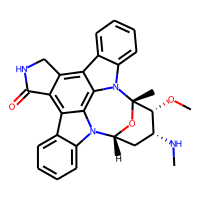
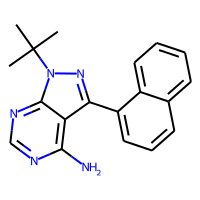
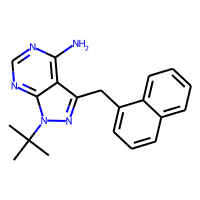
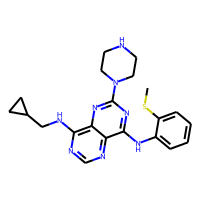
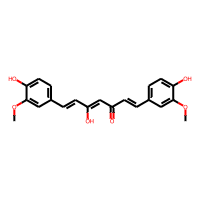
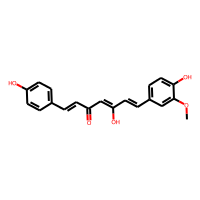
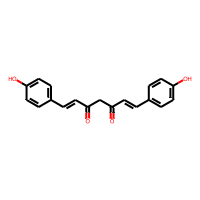
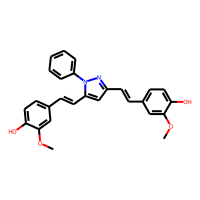
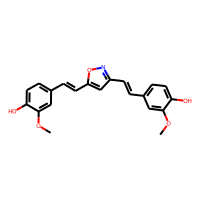
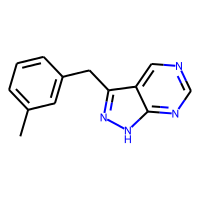
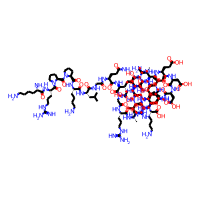
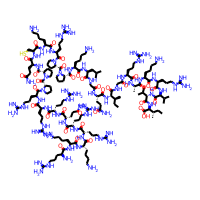
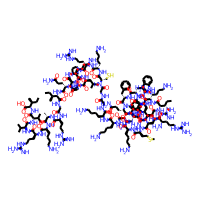
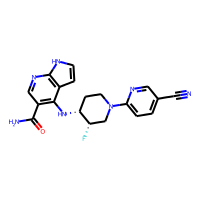
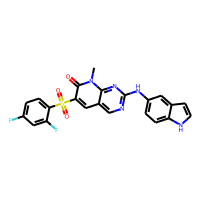
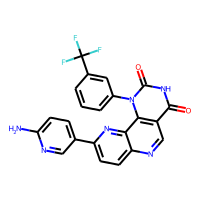
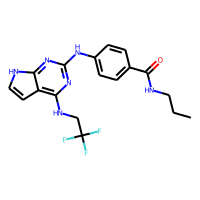
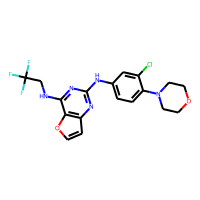
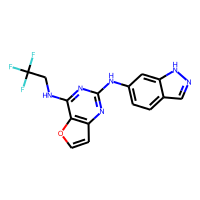
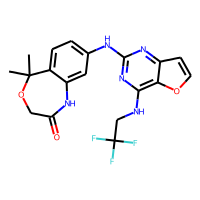

In [149]:
df.head()

In [45]:
print("dimension of diabetes data: {}".format(df.shape))

dimension of diabetes data: (27, 9)


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 0 to 29
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  27 non-null     object 
 1   canonical_smiles    27 non-null     object 
 2   class               27 non-null     object 
 3   MW                  27 non-null     float64
 4   LogP                27 non-null     float64
 5   NumHDonors          27 non-null     float64
 6   NumHAcceptors       27 non-null     float64
 7   ROMol               27 non-null     object 
 8   pIC50               27 non-null     float64
dtypes: float64(5), object(4)
memory usage: 2.1+ KB


In [47]:
selection = ['MW','LogP','NumHDonors','NumHAcceptors','class']
df = df[selection]

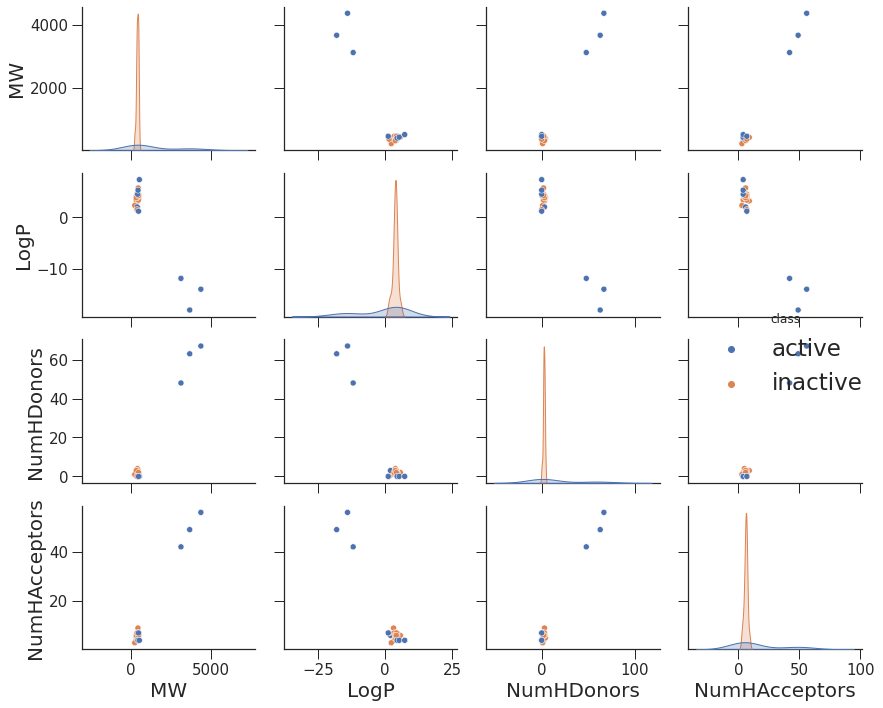

In [48]:
selection = ['class','MW','LogP','NumHDonors','NumHAcceptors']
sns.pairplot(df[selection], hue='class')
plt.tight_layout()

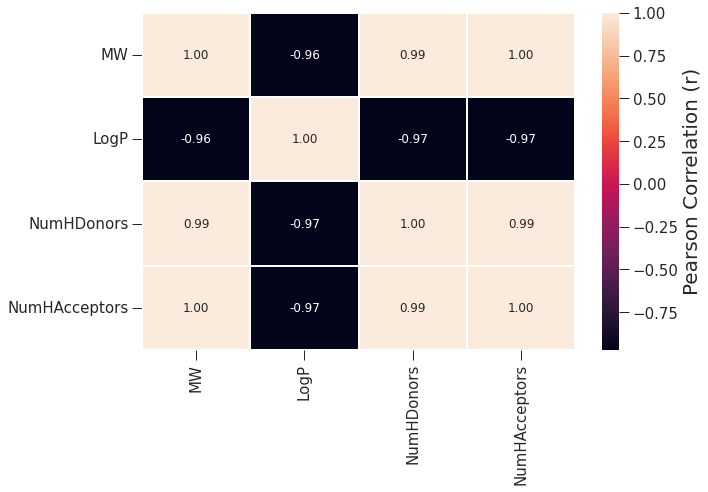

In [49]:
plt.figure(figsize=(10,7))
corr_mat = df.iloc[:,:-1].corr()
sns.heatmap(corr_mat, fmt='0.2f', annot=True, lw=2, cbar_kws={'label':'Pearson Correlation (r)'})
plt.xticks(size=15,rotation=90)
plt.yticks(size=15,rotation=0)
plt.tight_layout()
plt.savefig('Correlation.png',dpi=300);

/home/apolasa/python3.8/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


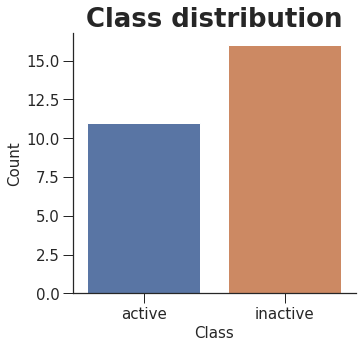

In [50]:
plt.figure(figsize=(5,5))
sns.countplot(df['class'],label='Count')
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylabel('Count',size=15)
plt.xlabel('Class',size=15)
sns.despine(top=True)
plt.title('Class distribution',size=26, weight='bold')
plt.tight_layout()
plt.savefig('Class-distribution.png');

In [51]:
df['class'] = df['class'].map({'inactive':0, 'active':1})

In [52]:
X = df.iloc[:,:-1].values   ##features selection
y = df.iloc[:,-1].values    ## target selection

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=27)

In [54]:
rs = SMOTE(sampling_strategy='auto')
X_train,y_train = rs.fit_resample(X_train,y_train)

/home/apolasa/python3.8/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

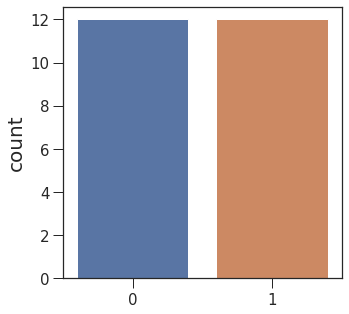

In [55]:
plt.figure(figsize=(5,5))
sns.countplot(y_train)

In [64]:
#k-Nearest Neighbors (KNN)
training_accuracy = [] 
test_accuracy = []
training_f1 = []
test_f1 = []

neighbors_settings = range(2,20)

for n_neighbors in neighbors_settings:
    print(f'working on neighbors {n_neighbors}')
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    
    y_train_pred=knn.predict(X_train)
    y_pred=knn.predict(X_test)
    
    training_accuracy.append(accuracy_score(y_train,y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_pred))
    
    training_f1.append(f1_score(y_train,y_train_pred))
    test_f1.append(f1_score(y_test, y_pred))
    

working on neighbors 2
working on neighbors 3
working on neighbors 4
working on neighbors 5
working on neighbors 6
working on neighbors 7
working on neighbors 8
working on neighbors 9
working on neighbors 10
working on neighbors 11
working on neighbors 12
working on neighbors 13
working on neighbors 14
working on neighbors 15
working on neighbors 16
working on neighbors 17
working on neighbors 18
working on neighbors 19


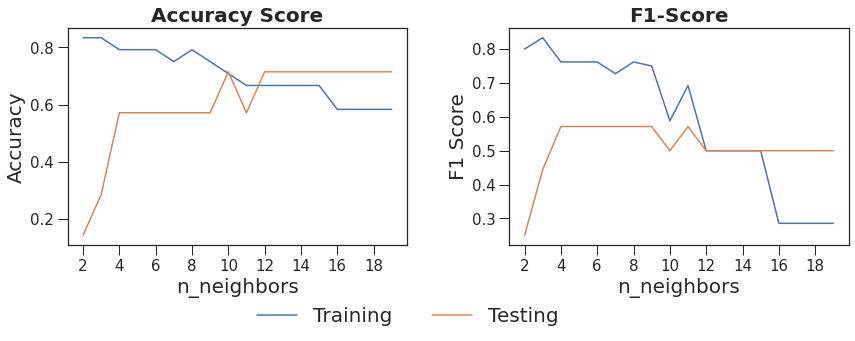

In [65]:
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

fig.add_subplot(2,2,1)
plt.plot(neighbors_settings, training_accuracy, label='training accuracy')
plt.plot(neighbors_settings, test_accuracy, label='test accuracy')
plt.ylabel('Accuracy',size=20)
plt.xticks(range(2,20,2),size=15)
plt.yticks(size=15)
plt.xlabel('n_neighbors',size=20)
plt.title('Accuracy Score',size=20, weight='bold')
plt.legend([],frameon=False, prop={'size':20})

fig.add_subplot(2,2,2)
plt.plot(neighbors_settings, training_f1)
plt.plot(neighbors_settings, test_f1)
plt.xticks(range(2,20,2),size=15)
plt.yticks(size=15)
plt.ylabel('F1 Score',size=20)
plt.xlabel('n_neighbors',size=20)
plt.title('F1-Score',size=20,weight='bold')
plt.legend(['Training','Testing'],frameon=False, bbox_to_anchor=(0.2,-0.2), ncol=2, prop={'size':20});

In [66]:
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('F1-score of K-NN classifier on test set: {:.2f}'.format(f1_score(y_test, y_pred)))

Accuracy of K-NN classifier on test set: 0.79
Accuracy of K-NN classifier on test set: 0.57
F1-score of K-NN classifier on test set: 0.57


In [67]:
def normalized_confusion_matrix(y_test, conf_mat, model):
    _ , counts = np.unique(y_test,return_counts=True)
    conf_mat = (conf_mat.T/counts).T
    plt.figure(figsize=(6,5))
    ax=sns.heatmap(conf_mat,fmt='.2f',annot=True,annot_kws={'size':20},lw=2, cbar=True, cbar_kws={'label':'% Class accuracy'})
    plt.title(f'Confusion Matrix ({model})',size=22)
    plt.xticks(size=20)
    plt.yticks(size=20)
    ax.figure.axes[-1].yaxis.label.set_size(20) ##colorbar label
    cax = plt.gcf().axes[-1]  ##colorbar ticks
    cax.tick_params(labelsize=20) ## colorbar ticks
    plt.savefig(f'confusion-matrix-{model}.png',dpi=300)

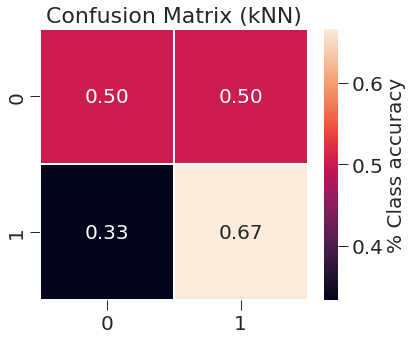

In [68]:
conf_mat = confusion_matrix(y_test,y_pred)
normalized_confusion_matrix(y_test,conf_mat, 'kNN')

In [69]:
k_fold_knn_accuracy = cross_val_score(knn, X, y, cv=10) ##10-fold cross validation
k_fold_knn_f1 = cross_val_score(knn, X, y, cv=10,scoring='f1_weighted') ##10-fold cross validation

In [70]:
print(f'Average accuracy after 10 fold cross validation :{k_fold_knn_accuracy.mean().round(2)} +/- {k_fold_knn_accuracy.std().round(2)}')
print(f'Average F1-score after 10 fold cross validation :{k_fold_knn_f1.mean().round(2)} +/- {k_fold_knn_f1.std().round(2)}')

Average accuracy after 10 fold cross validation :0.62 +/- 0.22
Average F1-score after 10 fold cross validation :0.49 +/- 0.28


In [71]:
#Decision Tree
max_depth=range(1,20)
training_accuracy = [] 
test_accuracy = []
training_f1 = []
test_f1 = []

for depth in max_depth : 
    tree = DecisionTreeClassifier(random_state=0, max_depth=depth, min_samples_leaf=1).fit(X_train, y_train)
    y_train_pred = tree.predict(X_train)
    y_pred = tree.predict(X_test)
    
    training_accuracy.append(accuracy_score(y_train,y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_pred))
    
    training_f1.append(f1_score(y_train,y_train_pred))
    test_f1.append(f1_score(y_test, y_pred))

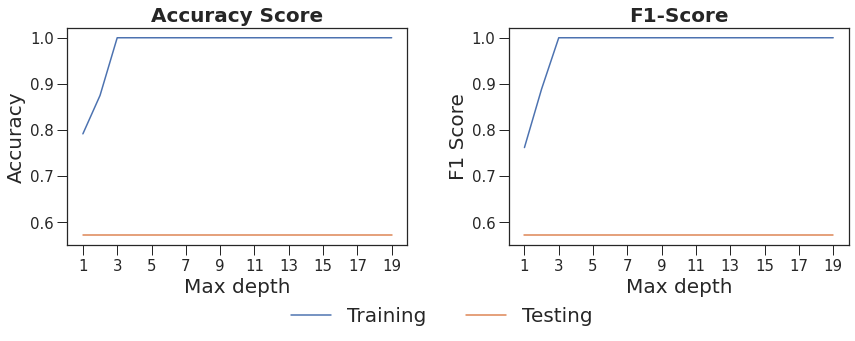

In [72]:
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

fig.add_subplot(2,2,1)
plt.plot(max_depth, training_accuracy, label='training accuracy')
plt.plot(max_depth, test_accuracy, label='test accuracy')
plt.ylabel('Accuracy',size=20)
plt.xlabel('Max depth',size=20)
plt.xticks(range(1,20,2),size=15)
plt.yticks(size=15)
plt.title('Accuracy Score',size=20, weight='bold')
plt.legend([],frameon=False)

fig.add_subplot(2,2,2)
plt.plot(max_depth, training_f1)
plt.plot(max_depth, test_f1)
plt.ylabel('F1 Score',size=20)
plt.xlabel('Max depth',size=20)
plt.xticks(range(1,20,2),size=15)
plt.yticks(size=15)
plt.title('F1-Score',size=20,weight='bold')
plt.legend(['Training','Testing'],frameon=False, bbox_to_anchor=(0.3,-0.2), prop = {'size':20}, ncol=2);

In [73]:
tree = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1, random_state=0).fit(X_train, y_train)
y_pred=tree.predict(X_test)

print("Accuracy on test: {:.3f}".format(accuracy_score(y_pred, y_test)))
print("F1-score on test set: {:.3f}".format(f1_score(y_pred, y_test)))

Accuracy on test: 0.571
F1-score on test set: 0.571


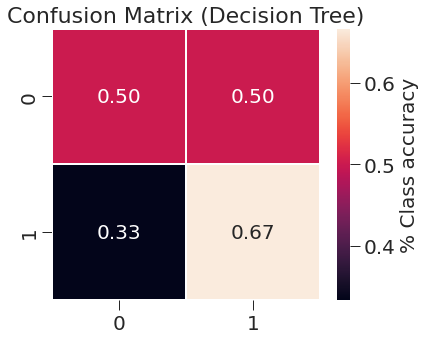

In [74]:
conf_mat = confusion_matrix(y_test,y_pred)
normalized_confusion_matrix(y_test,conf_mat,'Decision Tree')

In [75]:
k_fold_tree_accuracy = cross_val_score(tree, X, y, cv=10) ##10-fold cross validation
k_fold_tree_f1 = cross_val_score(tree, X, y, cv=10, scoring='f1_weighted') ##10-fold cross validation

In [76]:
print(f'Average accuracy after 10 fold cross validation :{k_fold_tree_accuracy.mean().round(2)} +/- {k_fold_tree_accuracy.std().round(2)}')
print(f'Average F1-score after 10 fold cross validation :{k_fold_tree_f1.mean().round(2)} +/- {k_fold_tree_f1.std().round(2)}')

Average accuracy after 10 fold cross validation :0.85 +/- 0.19
Average F1-score after 10 fold cross validation :0.82 +/- 0.24


<Figure size 576x432 with 0 Axes>

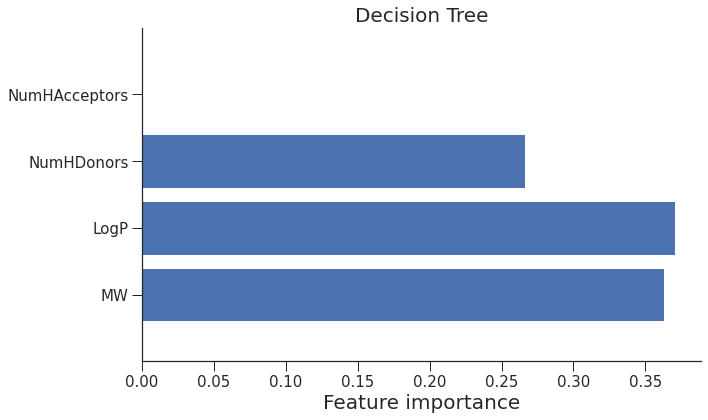

In [77]:
plt.figure(figsize=(8,6))
Clist=[1,0.01,100]

for C in Clist : 

    logreg = LogisticRegression(C=C,solver='newton-cg').fit(X_train, y_train) #keeping C=1 a
    y_train_pred = logreg.predict(X_train)
    y_pred = logreg.predict(X_test)

    
    data_features = [x for i,x in enumerate(df.columns[:-1]) if i!=8]
def plot_feature_importances(model, figure):
    n_features = 4
    plt.figure(figsize=(10,6))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data_features,size=15)
    plt.xticks(size=15)
    plt.xlabel('Feature importance',size=20,)
    #plt.ylabel('Feature',size=20)
    plt.ylim(-1, n_features)
    sns.despine(top=True)
    plt.title(f'{figure}',size=20)
    plt.tight_layout()
    plt.savefig(f'feature-image{figure}.png',dpi=300)

plot_feature_importances(tree,'Decision Tree')

In [78]:
rf = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
y_pred=rf.predict(X_test)

print("Accuracy on test: {:.3f}".format(accuracy_score(y_pred, y_test)))
print("F1-score on test set: {:.3f}".format(f1_score(y_pred, y_test)))

Accuracy on test: 0.714
F1-score on test set: 0.667


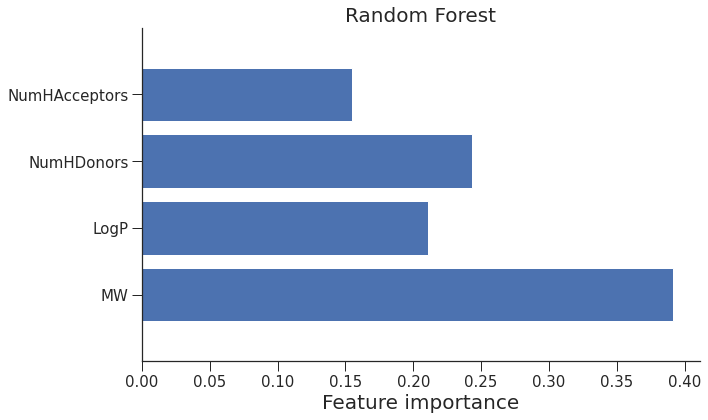

In [79]:
plot_feature_importances(rf, 'Random Forest')

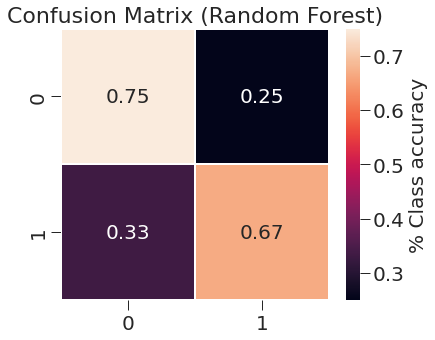

In [80]:
conf_mat = confusion_matrix(y_test,y_pred)
normalized_confusion_matrix(y_test,conf_mat,'Random Forest')

k_fold_rf_accuracy = cross_val_score(rf, X, y, cv=10) ##10-fold cross validation
k_fold_rf_f1 = cross_val_score(rf, X, y, cv=10, scoring='f1_weighted') ##10-fold cross validation

In [81]:
k_fold_rf_accuracy = cross_val_score(rf, X, y, cv=10) ##10-fold cross validation
k_fold_rf_f1 = cross_val_score(rf, X, y, cv=10, scoring='f1_weighted') ##10-fold cross validation

In [82]:
print(f'Average accuracy after 10 fold cross validation :{k_fold_tree_accuracy.mean().round(2)} +/- {k_fold_tree_accuracy.std().round(2)}')
print(f'Average F1-score after 10 fold cross validation :{k_fold_tree_f1.mean().round(2)} +/- {k_fold_tree_f1.std().round(2)}')

Average accuracy after 10 fold cross validation :0.85 +/- 0.19
Average F1-score after 10 fold cross validation :0.82 +/- 0.24


In [83]:
#Support Vector Machine (SVM)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

#SVM requiest feature scaling
svc = SVC().fit(X_train_scaled, y_train)
y_pred=svc.predict(X_test_scaled)

print("Accuracy on train: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_pred, y_test)))
print("F1-score on test set: {:.3f}".format(f1_score(y_pred, y_test)))


Accuracy on train: 0.583
Accuracy on test: 0.714
F1-score on test set: 0.500


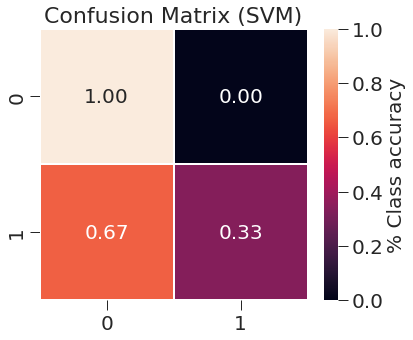

In [84]:
conf_mat = confusion_matrix(y_test,y_pred)
normalized_confusion_matrix(y_test,conf_mat,'SVM')

In [85]:
k_fold_svm_accuracy = cross_val_score(svc, scaler.fit_transform(X), y, cv=10) ##10-fold cross validation
k_fold_svm_f1 = cross_val_score(svc, scaler.fit_transform(X), y, cv=10, scoring='f1_weighted') ##10-fold cross validation

In [86]:
print(f'Average accuracy after 10 fold cross validation : {k_fold_svm_accuracy.mean().round(2)} +/- {k_fold_svm_accuracy.std().round(2)}')
print(f'Average F1-score after 10 fold cross validation : {k_fold_svm_f1.mean().round(2)} +/- {k_fold_svm_f1.std().round(2)}')

Average accuracy after 10 fold cross validation : 0.68 +/- 0.23
Average F1-score after 10 fold cross validation : 0.58 +/- 0.3


In [87]:
all_accuracies = [k_fold_knn_accuracy.mean().round(2),
                   k_fold_tree_accuracy.mean().round(2),
                   k_fold_rf_accuracy.mean().round(2),
                   k_fold_svm_accuracy.mean().round(2),]

all_accuracies_errors = [k_fold_knn_accuracy.std().round(2),
                       k_fold_tree_accuracy.std().round(2),
                       k_fold_rf_accuracy.std().round(2),
                       k_fold_svm_accuracy.std().round(2),]

In [88]:
all_f1 = [k_fold_knn_f1.mean().round(2),
                   k_fold_tree_f1.mean().round(2),
                   k_fold_rf_f1.mean().round(2),
                   k_fold_svm_f1.mean().round(2),]

all_f1_errors = [k_fold_knn_f1.std().round(2),
                   k_fold_tree_f1.std().round(2),
                   k_fold_rf_f1.std().round(2),
                   k_fold_svm_f1.std().round(2),]

In [89]:
models=['kNN','Decision Tree','Random Forest','SVM']

In [90]:
model_data = pd.DataFrame([all_accuracies,all_accuracies_errors,all_f1,all_f1_errors],columns=models, index = ['Accuracy','STD_acc','F1-macro','STD_f1']).T

In [91]:
model_data.style.background_gradient(cmap='coolwarm',axis=0)

,Accuracy,STD_acc,F1-macro,STD_f1
kNN,0.620000,0.220000,0.490000,0.280000
Decision Tree,0.850000,0.190000,0.820000,0.240000
Random Forest,0.800000,0.210000,0.750000,0.270000
SVM,0.680000,0.230000,0.580000,0.300000


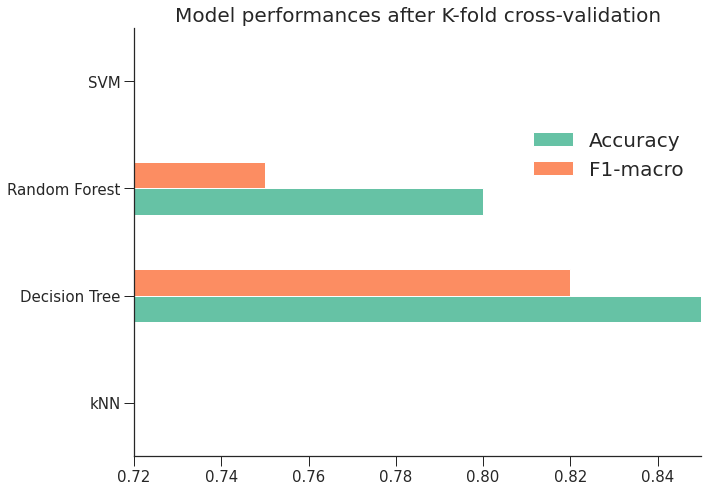

In [92]:
color=sns.color_palette('Set2')
model_data[['Accuracy','F1-macro']].plot.barh(figsize=(10,7),color=color)
plt.legend(frameon=False,bbox_to_anchor=(1,0.8), prop={'size':20})
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim([0.72,0.85]);
plt.title('Model performances after K-fold cross-validation',size=20)
sns.despine(top=True)
plt.tight_layout()
plt.savefig('model-comparision.png',dpi=300)

In [93]:
#PaDEL-Descriptor
df3 = pd.read_csv('bioactivity_class_pic50.csv')

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,ROMol,pIC50
0,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,active,466.541,4.3540,2.0,6.0,,9.000000
1,CHEMBL213618,CNc1nccc(-c2ccc(C(=O)N[C@H](CN)Cc3ccc(Cl)cc3Cl...,intermediate,436.368,3.8534,3.0,6.0,,5.096910
2,CHEMBL264406,CC(C)(C)n1nc(-c2cccc3ccccc23)c2c(N)ncnc21,active,317.396,3.9837,1.0,5.0,,7.013228

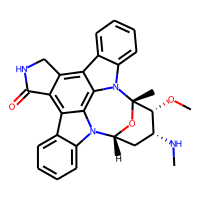
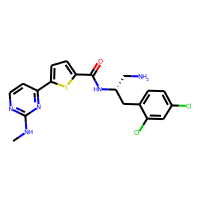
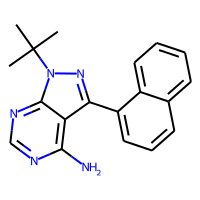

In [126]:
df3.head(3)

In [95]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df3[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [96]:
! cat molecule.smi | head -5

CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(=O)NC4	CHEMBL388978
CNc1nccc(-c2ccc(C(=O)N[C@H](CN)Cc3ccc(Cl)cc3Cl)s2)n1	CHEMBL213618
CC(C)(C)n1nc(-c2cccc3ccccc23)c2c(N)ncnc21	CHEMBL264406
CC(C)(C)n1nc(Cc2cccc3ccccc23)c2c(N)ncnc21	CHEMBL573578
CSc1ccccc1Nc1nc(N2CCNCC2)nc2c(NCC3CC3)ncnc12	CHEMBL2017214


In [97]:
! cat molecule.smi | wc -l

30


In [98]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [99]:
! bash padel.sh

Processing CHEMBL388978 in molecule.smi (1/30). 
Processing CHEMBL213618 in molecule.smi (2/30). Average speed: 3.31 s/mol.
Processing CHEMBL264406 in molecule.smi (3/30). Average speed: 1.86 s/mol.
Processing CHEMBL573578 in molecule.smi (4/30). Average speed: 1.33 s/mol.
Processing CHEMBL2017214 in molecule.smi (5/30). Average speed: 1.07 s/mol.
Processing CHEMBL116438 in molecule.smi (6/30). Average speed: 0.90 s/mol.
Processing CHEMBL179512 in molecule.smi (7/30). Average speed: 0.78 s/mol.
Processing CHEMBL105350 in molecule.smi (8/30). Average speed: 0.70 s/mol.
Processing CHEMBL258741 in molecule.smi (9/30). Average speed: 0.63 s/mol.
Processing CHEMBL180239 in molecule.smi (10/30). Average speed: 0.60 s/mol.
Processing CHEMBL181529 in molecule.smi (11/30). Average speed: 0.56 s/mol.
Processing CHEMBL2324596 in molecule.smi (12/30). Average speed: 0.53 s/mol.
Processing CHEMBL2335479 in molecule.smi (13/30). Average speed: 0.50 s/mol.
Processing CHEMBL2335442 in molecule.smi (14

In [100]:
df3_X = pd.read_csv('descriptors_output.csv')
df3_X = df3_X.drop(columns=['Name'])

In [101]:
df3_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [102]:
df3_y=df3['pIC50']
df3_y

0     9.000000
1     5.096910
2     7.013228
3     8.096910
4     4.397940
5     4.886057
6     4.619789
7     4.431798
8     4.431798
9     5.826814
10    4.944240
11    5.000000
12    7.301030
13    7.397940
14    7.522879
15    6.000000
16    5.000000
17    5.000000
18    5.000000
19    5.000000
20    5.000000
21    5.000000
22    5.000000
23    5.000000
24    6.075721
25    6.102373
26    6.091515
27    5.987163
28    4.000000
29    6.000000
Name: pIC50, dtype: float64

In [103]:
dataset3=pd.concat([df3_X,df3_y],axis=1)
dataset3

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,9.000000
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.096910
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.013228
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,8.096910
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.397940
5,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.886057
6,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.619789
7,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.431798
8,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.431798
9,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.826814


In [104]:
dataset3.to_csv('camk2a_pIC50_pubchem_fp.csv', index=False)

In [105]:
df=pd.read_csv('camk2a_pIC50_pubchem_fp.csv')

In [106]:
df

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,9.000000
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.096910
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.013228
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,8.096910
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.397940
5,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.886057
6,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.619789
7,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.431798
8,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.431798
9,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.826814


In [107]:
X=df.drop(columns=['pIC50'])

In [108]:
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [109]:
y=df['pIC50']
y

0     9.000000
1     5.096910
2     7.013228
3     8.096910
4     4.397940
5     4.886057
6     4.619789
7     4.431798
8     4.431798
9     5.826814
10    4.944240
11    5.000000
12    7.301030
13    7.397940
14    7.522879
15    6.000000
16    5.000000
17    5.000000
18    5.000000
19    5.000000
20    5.000000
21    5.000000
22    5.000000
23    5.000000
24    6.075721
25    6.102373
26    6.091515
27    5.987163
28    4.000000
29    6.000000
Name: pIC50, dtype: float64

In [110]:
X.shape

(30, 881)

In [111]:
y.shape

(30,)

In [112]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [113]:
X.shape

(30, 193)

In [114]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [115]:
X_train.shape,y_train.shape

((24, 193), (24,))

In [116]:
X_test.shape, y_test.shape

((6, 193), (6,))

In [117]:
from sklearn.ensemble import RandomForestRegressor

In [118]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [119]:
print("Coefficient of determination R^2 <-- on train set: {}".format(model.score(X_train, y_train)))

Coefficient of determination R^2 <-- on train set: 0.9204742099696388


In [120]:
print("Coefficient of determination R^2 <-- on train set: {}".format(model.score(X_test, y_test)))

Coefficient of determination R^2 <-- on train set: -3.4616015844624215


In [121]:
Y_pred = model.predict(X_test)

/home/apolasa/python3.8/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

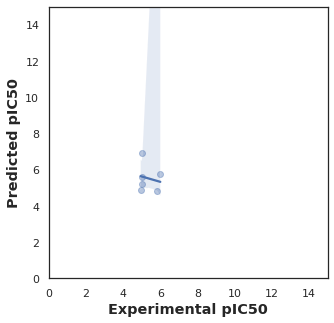

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 15)
ax.set_ylim(0, 15)
ax.figure.set_size_inches(5, 5)
plt.show

In [131]:
#Autodock 
selection = ['molecule_chembl_id','canonical_smiles','ROMol']
df3_selection = df3[selection]

,molecule_chembl_id,canonical_smiles,ROMol
0,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,
1,CHEMBL213618,CNc1nccc(-c2ccc(C(=O)N[C@H](CN)Cc3ccc(Cl)cc3Cl...,
2,CHEMBL264406,CC(C)(C)n1nc(-c2cccc3ccccc23)c2c(N)ncnc21,
3,CHEMBL573578,CC(C)(C)n1nc(Cc2cccc3ccccc23)c2c(N)ncnc21,
4,CHEMBL2017214,CSc1ccccc1Nc1nc(N2CCNCC2)nc2c(NCC3CC3)ncnc12,
5,CHEMBL116438,COc1cc(/C=C/C(=O)/C=C(O)/C=C/c2ccc(O)c(OC)c2)c...,
6,CHEMBL179512,COc1cc(/C=C/C(O)=C/C(=O)/C=C/c2ccc(O)cc2)ccc1O,
7,CHEMBL105350,O=C(/C=C/c1ccc(O)cc1)CC(=O)/C=C/c1ccc(O)cc1,
8,CHEMBL258741,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)n(-c3ccc...,
9,CHEMBL180239,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)[nH]n2)c...,

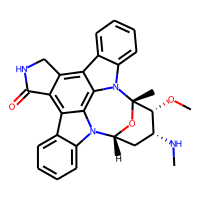
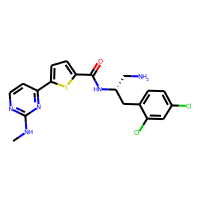
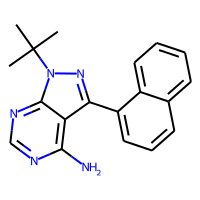
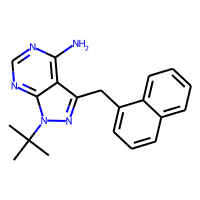
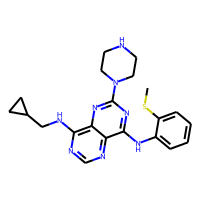
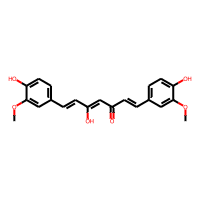
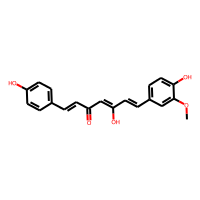
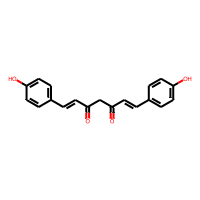
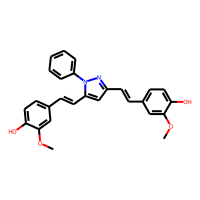
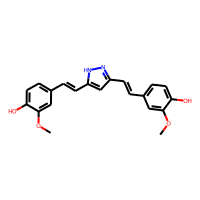

In [133]:
df3_selection.head(10)

In [137]:
df=pd.read_csv('results1.dat')

In [138]:
df

,score
0,-12.5
1,-8.2
2,-7.7
3,-10.4
4,-8.3
5,-8.1
6,-7.9
7,-7.9
8,-10.2
9,-8.8


,molecule_chembl_id,canonical_smiles,ROMol,score
0,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,,-12.5
1,CHEMBL213618,CNc1nccc(-c2ccc(C(=O)N[C@H](CN)Cc3ccc(Cl)cc3Cl...,,-8.2
2,CHEMBL264406,CC(C)(C)n1nc(-c2cccc3ccccc23)c2c(N)ncnc21,,-7.7
3,CHEMBL573578,CC(C)(C)n1nc(Cc2cccc3ccccc23)c2c(N)ncnc21,,-10.4
4,CHEMBL2017214,CSc1ccccc1Nc1nc(N2CCNCC2)nc2c(NCC3CC3)ncnc12,,-8.3
5,CHEMBL116438,COc1cc(/C=C/C(=O)/C=C(O)/C=C/c2ccc(O)c(OC)c2)c...,,-8.1
6,CHEMBL179512,COc1cc(/C=C/C(O)=C/C(=O)/C=C/c2ccc(O)cc2)ccc1O,,-7.9
7,CHEMBL105350,O=C(/C=C/c1ccc(O)cc1)CC(=O)/C=C/c1ccc(O)cc1,,-7.9
8,CHEMBL258741,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)n(-c3ccc...,,-10.2
9,CHEMBL180239,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)[nH]n2)c...,,-8.8

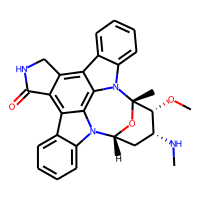
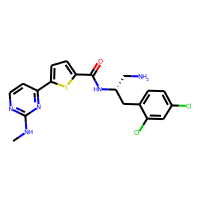
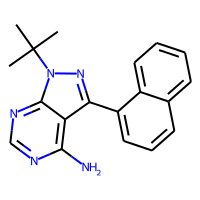
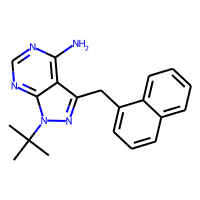
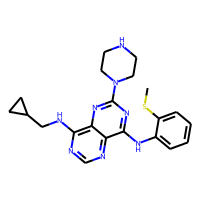
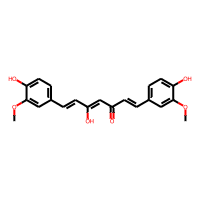
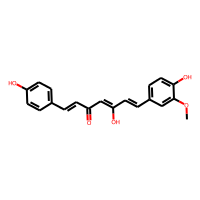
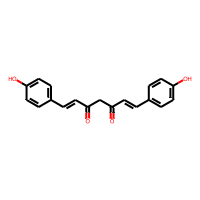
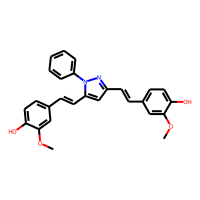
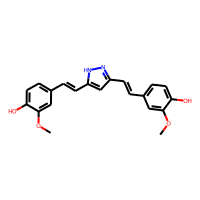

In [139]:
# Combining the two columns
df_combined_Autodock = pd.concat([df3_selection.head(10),df],axis=1)
df_combined_Autodock

In [144]:
sorted_df = df_combined_Autodock.sort_values(by=["score"], ascending=True)

,molecule_chembl_id,canonical_smiles,ROMol,score
0,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,,-12.5
3,CHEMBL573578,CC(C)(C)n1nc(Cc2cccc3ccccc23)c2c(N)ncnc21,,-10.4
8,CHEMBL258741,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)n(-c3ccc...,,-10.2
9,CHEMBL180239,COc1cc(/C=C/c2cc(/C=C/c3ccc(O)c(OC)c3)[nH]n2)c...,,-8.8
4,CHEMBL2017214,CSc1ccccc1Nc1nc(N2CCNCC2)nc2c(NCC3CC3)ncnc12,,-8.3
1,CHEMBL213618,CNc1nccc(-c2ccc(C(=O)N[C@H](CN)Cc3ccc(Cl)cc3Cl...,,-8.2
5,CHEMBL116438,COc1cc(/C=C/C(=O)/C=C(O)/C=C/c2ccc(O)c(OC)c2)c...,,-8.1
6,CHEMBL179512,COc1cc(/C=C/C(O)=C/C(=O)/C=C/c2ccc(O)cc2)ccc1O,,-7.9
7,CHEMBL105350,O=C(/C=C/c1ccc(O)cc1)CC(=O)/C=C/c1ccc(O)cc1,,-7.9
2,CHEMBL264406,CC(C)(C)n1nc(-c2cccc3ccccc23)c2c(N)ncnc21,,-7.7

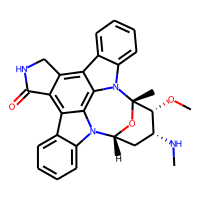
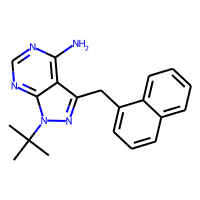
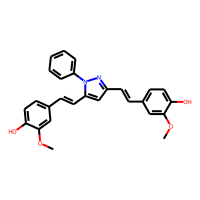
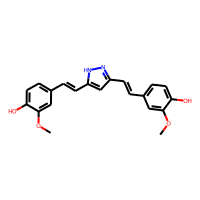
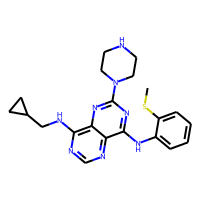
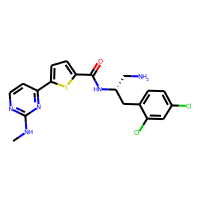
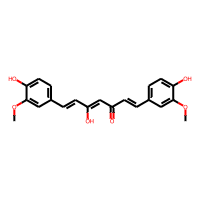
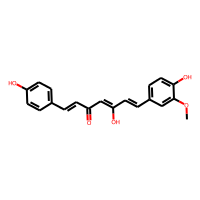
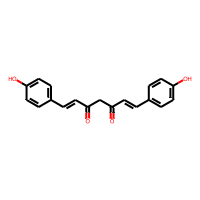
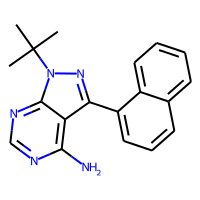

In [145]:
sorted_df

In [146]:
sorted_df.to_csv('camk2a_Top_10_docking_scores.csv', index=False)